In [49]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [50]:
OutputEx = pd.read_excel("ModelDataReduced2.xlsx",sheet_name="Output")
Input = []
Output = []
for i in range(10):
    Input.append(pd.read_excel(r"ParticipantDirectory",sheet_name=f"Input{i+1}").to_numpy())
    Output.append(pd.read_excel(r"ParticipantDirectory",sheet_name=f"Output{i+1}").to_numpy())
FrameSkip = 60*5 #60 frames is 1 second
TimeSkip = 0.0167*FrameSkip #for 60Hz
print(f"Time skip of {TimeSkip}")



Time skip of 5.01


In [51]:
for i in range(len(Input)):
    Output[i] = Output[i][FrameSkip:]
    Input[i] = Input[i][:-FrameSkip]
    print(f"Gaps between data lengths for {i+1}:", len(Input[i])-len(Output[i]))

Gaps between data lengths for 1: 0
Gaps between data lengths for 2: 0
Gaps between data lengths for 3: 0
Gaps between data lengths for 4: 0
Gaps between data lengths for 5: 0
Gaps between data lengths for 6: 0
Gaps between data lengths for 7: 0
Gaps between data lengths for 8: 0
Gaps between data lengths for 9: 0
Gaps between data lengths for 10: 0


In [52]:

for i in range(len(Input)):
    print(f"Input dataset {i+1} missing values:",np.count_nonzero(np.isnan(np.array(Input[i])))) #this is to count the number of empty cells in an array
for i in range(len(Input)):
    print(f"Output dataset {i+1} missing values:",np.count_nonzero(np.isnan(np.array(Output[i]))))
    

Input dataset 1 missing values: 0
Input dataset 2 missing values: 0
Input dataset 3 missing values: 0
Input dataset 4 missing values: 0
Input dataset 5 missing values: 0
Input dataset 6 missing values: 0
Input dataset 7 missing values: 0
Input dataset 8 missing values: 0
Input dataset 9 missing values: 0
Input dataset 10 missing values: 0
Output dataset 1 missing values: 0
Output dataset 2 missing values: 0
Output dataset 3 missing values: 0
Output dataset 4 missing values: 0
Output dataset 5 missing values: 0
Output dataset 6 missing values: 0
Output dataset 7 missing values: 0
Output dataset 8 missing values: 0
Output dataset 9 missing values: 0
Output dataset 10 missing values: 0


In [53]:
import matplotlib.pyplot as plt

def remove_outliers_3sigma(arr):
    # Step 1: Calculate mean and standard deviation for each row
    row_means = np.mean(arr, axis=1)
    row_stds = np.std(arr, axis=1)

    # Step 2: Identify outliers using the 3-sigma rule
    lower_bound = row_means - 3 * row_stds
    upper_bound = row_means + 3 * row_stds

    # Step 3: Replace or remove outliers
    cleaned_arr = np.copy(arr)  # Create a copy to avoid modifying the original array

    for i in range(arr.shape[0]):
        outliers = (arr[i, :] < lower_bound[i]) | (arr[i, :] > upper_bound[i])
        cleaned_arr[i, outliers] = np.nan  # Replace outliers with NaN, you can modify this based on your requirement

    return cleaned_arr

for i in range(len(Input)):
    print(f"Number of removed values from dataset {i+1} = ",np.sum(np.isnan(remove_outliers_3sigma(Output[i])))+np.sum(np.isnan(remove_outliers_3sigma(Input[i]))))
    


Number of removed values from dataset 1 =  0
Number of removed values from dataset 2 =  0
Number of removed values from dataset 3 =  0
Number of removed values from dataset 4 =  0
Number of removed values from dataset 5 =  0
Number of removed values from dataset 6 =  0
Number of removed values from dataset 7 =  0
Number of removed values from dataset 8 =  0
Number of removed values from dataset 9 =  0
Number of removed values from dataset 10 =  0


In [54]:
import matplotlib.pyplot as plt

def smooth_2d_array(data, window_size):
    smoothed_data = np.zeros_like(data)

    # Iterate through each column
    for col in range(data.shape[1]):
        column = data[:, col]

        # Apply average smoothing using a moving window
        smoothed_column = np.convolve(column, np.ones(window_size)/window_size, mode='same')

        # Store the smoothed column in the result
        smoothed_data[:, col] = smoothed_column

    return smoothed_data


import numpy as np
from scipy.ndimage import gaussian_filter, median_filter
from scipy.signal import savgol_filter
import pandas as pd
import matplotlib.pyplot as plt

window_size = 3
X_train=[]
X_test=[]
y_train=[]
y_test=[]
for i in range(len(Input)):
    Input[i],Output[i] = smooth_2d_array(Input[i], window_size),smooth_2d_array(Output[i], window_size)
    X_traint, X_testt, y_traint, y_testt = train_test_split(Input[i], Output[i], test_size=0.2)
    
    scaler = StandardScaler()
    X_traint = scaler.fit_transform(X_traint)
    X_testt = scaler.transform(X_testt)
    
    X_train.append(X_traint)
    X_test.append(X_testt)
    y_train.append(y_traint)
    y_test.append(y_testt)


In [55]:

import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from kerastuner.tuners import RandomSearch
import kerastuner
import numpy as np

weights = [1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0]
#Wrists top Priority. Elbows next priority. Shoulders and nose final priority. 

def custom_loss(y_true, y_pred):
    # Assign weights to different features
    #This is for the reduced output data
    feature_weights = tf.constant(weights)#<---Weightings must be decided. what are the most and least importantt features
     
    loss = tf.reduce_mean(tf.square(y_true - y_pred)*feature_weights)
    return loss

def custom_loss2(y_true, y_pred):
    # Assign weights to different features
    #This is for the reduced output data
    feature_weights = tf.constant(weights)
     
    loss = tf.abs(tf.reduce_mean((y_true - y_pred)*feature_weights))
    return loss


def custom_loss3(y_true, y_pred):
    #Wrist arm length check , mse
    RightForearmLengthVec = y_pred[-1,6:9]-y_pred[-1,9:12]
    LeftForearmLengthVec = y_pred[-1,15:18]-y_pred[-1,18:21]
    
    LeftForearmLength = tf.sqrt(tf.reduce_sum(tf.square(LeftForearmLengthVec)))
    RightForearmLength = tf.sqrt(tf.reduce_sum(tf.square(RightForearmLengthVec)))
    loss = tf.reduce_mean(tf.square(LeftForearmLength - RightForearmLength))
    return loss
    
    
def custom_loss4(y_true, y_pred):
    #Wrist arm length check , mae
    RightForearmLengthVec = y_pred[-1,6:9]-y_pred[-1,9:12]
    LeftForearmLengthVec = y_pred[-1,15:18]-y_pred[-1,18:21]
    
    LeftForearmLength = tf.sqrt(tf.reduce_sum(tf.square(LeftForearmLengthVec)))
    RightForearmLength = tf.sqrt(tf.reduce_sum(tf.square(RightForearmLengthVec)))
    loss = tf.abs(tf.reduce_mean((LeftForearmLength - RightForearmLength)))
    return loss

def custom_loss5(y_true, y_pred):
    #Forearm vector check for right arm , mae
    RightForearmLengthVec = y_pred[-1,6:9]-y_pred[-1,9:12]
    RightForrearmLengthVecT = y_true[-1,6:9]-y_true[-1,9:12]
    loss = tf.abs(tf.reduce_mean(tf.abs(tf.linalg.cross(RightForearmLengthVec,RightForrearmLengthVecT))))
    return loss

def custom_loss6(y_true, y_pred):
    #Forearm vector check for right arm , mse
    RightForearmLengthVec = y_pred[-1,6:9]-y_pred[-1,9:12]
    RightForrearmLengthVecT = y_true[-1,6:9]-y_true[-1,9:12]
    loss = tf.reduce_mean(tf.square(tf.linalg.cross(RightForearmLengthVec,RightForrearmLengthVecT)))
    return loss

def custom_loss7(y_true, y_pred):
    #Forearm vector check for left arm , mae
    LeftForearmLengthVec = y_pred[-1,15:18]-y_pred[-1,18:21]
    LeftForearmLengthVecT = y_true[-1,15:18]-y_true[-1,18:21]
    loss = tf.abs(tf.reduce_mean(tf.abs(tf.linalg.cross(LeftForearmLengthVec, LeftForearmLengthVecT))))
    return loss

def custom_loss8(y_true, y_pred):
    #Forearm vector check for left arm , mae
    LeftForearmLengthVec = y_pred[-1,15:18]-y_pred[-1,18:21]
    LeftForearmLengthVecT = y_true[-1,15:18]-y_true[-1,18:21]
    loss = tf.reduce_mean(tf.square(tf.linalg.cross(LeftForearmLengthVec, LeftForearmLengthVecT)))
    return loss

def custom_loss9(y_true, y_pred):
    #Forearm vector check for right arm , mae
    RightArmLengthVec = y_pred[-1,3:6]-y_pred[-1,6:9]
    RightArmLengthVecT = y_true[-1,3:6]-y_true[-1,6:9]
    loss = tf.abs(tf.reduce_mean(tf.abs(tf.linalg.cross(RightArmLengthVec,RightArmLengthVecT))))
    return loss

def custom_loss10(y_true, y_pred):
    #Forearm vector check for right arm , mse
    RightArmLengthVec = y_pred[-1,3:6]-y_pred[-1,6:9]
    RightArmLengthVecT = y_true[-1,3:6]-y_true[-1,6:9]
    loss = tf.reduce_mean(tf.square(tf.linalg.cross(RightArmLengthVec,RightArmLengthVecT)))
    return loss

def custom_loss11(y_true, y_pred):
    #Forearm vector check for left arm , mae
    LeftArmLengthVec = y_pred[-1,12:15]-y_pred[-1,15:18]
    LeftArmLengthVecT = y_true[-1,12:15]-y_true[-1,15:18]
    loss = tf.abs(tf.reduce_mean(tf.abs(tf.linalg.cross(LeftArmLengthVec, LeftArmLengthVecT))))
    return loss

def custom_loss12(y_true, y_pred):
    #Forearm vector check for left arm , mae
    LeftArmLengthVec = y_pred[-1,12:15]-y_pred[-1,15:18]
    LeftArmLengthVecT = y_true[-1,12:15]-y_true[-1,15:18]
    loss = tf.reduce_mean(tf.square(tf.linalg.cross(LeftArmLengthVec, LeftArmLengthVecT)))
    return loss

#-1 put in the arrays because the array has 3 rows because of the LSTM layers. So using the last one represents the output.

# Define the model-building function
def build_model(hp):
    model = Sequential([Input(shape=(X_train[0].shape[1], 1))])

    # Add dynamic number of LSTM layers
    for i in range(hp.Int('num_lstm_layers', min_value=1, max_value=5)):
        model.add(LSTM(hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32), activation="relu", return_sequences=(i < hp.get('num_lstm_layers') - 1)))

    model.add(Dense(y_test[0].shape[1], activation="linear"))
    
    model.compile(optimizer='adam', loss=["mae","mse",custom_loss,custom_loss2,custom_loss3,custom_loss4,custom_loss5,custom_loss6,custom_loss7,custom_loss8,custom_loss9,custom_loss10,custom_loss11,custom_loss12],
                  metrics=["mae","mse",custom_loss,custom_loss2,custom_loss3,custom_loss4,custom_loss5,custom_loss6,custom_loss7,custom_loss8,custom_loss9,custom_loss10,custom_loss11,custom_loss12])
    return model

# Instantiate the tuner with the specified directory
objective = kerastuner.Objective("custom_loss", direction="min")
objective2 = kerastuner.Objective("custom_loss2", direction="min")
objective3 = kerastuner.Objective("custom_loss3", direction="min")
objective4 = kerastuner.Objective("custom_loss4", direction="min")
objective5 = kerastuner.Objective("custom_loss5", direction="min")
objective6 = kerastuner.Objective("custom_loss6", direction="min")
objective7 = kerastuner.Objective("custom_loss7", direction="min")
objective8 = kerastuner.Objective("custom_loss8", direction="min")
objective9 = kerastuner.Objective("custom_loss9", direction="min")
objective10 = kerastuner.Objective("custom_loss10", direction="min")
objective11 = kerastuner.Objective("custom_loss11", direction="min")
objective12 = kerastuner.Objective("custom_loss12", direction="min")

tuner = RandomSearch(
    build_model,
    objective=["mae","mse",objective,objective2,objective3,objective4,objective5,objective6,objective7,objective8,objective9,objective10,objective11,objective12],
    max_trials=100,  # Adjust as needed
    directory="Participant6Model_MoreCustomLossFunctions_MoreTrials", #WHEN CHANGING TO OUTPUTREEDUCEDFEATUREFOCUS CHANGE LOSS AND METRICS TO [custom_loss,custom_loss2,custom_loss3]
    project_name="UniModel"
)

# Search for the best hyperparameter configuration
for i in range(len(X_train)):
    tuner.search(X_train[i], y_train[i], epochs=5)

# Get the best model
model = tuner.get_best_models(num_models=1)[0]


INFO:tensorflow:Reloading Tuner from Participant5Model_MoreCustomLossFunctions_MoreTrials\UniModel\tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


In [56]:

model.summary()
custom_optimizer = tf.optimizers.Adam(learning_rate=0.0001) #default is 0.0001
model.compile(optimizer=custom_optimizer,loss=[["mae","mse",custom_loss,custom_loss2,custom_loss3,custom_loss4,custom_loss5,custom_loss6,custom_loss7,custom_loss8,custom_loss9,custom_loss10,custom_loss11,custom_loss12]],
              metrics=[["mae","mse",custom_loss,custom_loss2,custom_loss3,custom_loss4,custom_loss5,custom_loss6,custom_loss7,custom_loss8,custom_loss9,custom_loss10,custom_loss11,custom_loss12]])
# Train the model

history = []

for i in range(len(X_train)):
    history.append(model.fit(X_train[i], y_train[i], epochs=5, batch_size=32)) #return back to epochs 5 batch size 32
    """
    plt.figure(figsize=(6, 3))
    plt.plot(history[0].history['loss'], label='Training Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    """


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 256)           264192    
                                                                 
 lstm_1 (LSTM)               (None, 32)                36992     
                                                                 
 dense (Dense)               (None, 21)                693       
                                                                 
Total params: 301,877
Trainable params: 301,877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
34/34 [==============================] - 13s 262ms/step - loss: 1133.6725 - mae: 1133.6725 - mse: 2799942.0000 - custom_loss: 5180830.5000 - custom_loss2: 1521.1385 - custom_loss3: 0.0545 - custom_loss4: 0.2202 - custom_loss5: 71.6890 - custom_loss6: 7317.8184 - custom_loss7: 31.3705 - custom_loss8: 280

In [57]:
PredictedArray = []
PredictedArrayt = []
mae = []
mse=[]
for j in range(len(X_train)):
    PredictedArraya = []
    for i in range(X_test[j].shape[0]):
        PredictedArrayt.append(model.predict(np.reshape(X_test[j][i,:], (1, -1)),verbose=0)[0])
        PredictedArraya.append(model.predict(np.reshape(X_test[j][i,:], (1, -1)),verbose=0)[0])
    
    mae_per_column = np.mean(np.abs(y_test[j] - PredictedArraya), axis=0)
    """
    plt.figure(figsize=(15, 6))
    plt.bar(OutputEx.columns, mae_per_column,width=1)

    plt.xlabel('Columns')
    plt.ylabel('Mean Absolute Error')
    plt.title('Mean Absolute Error for Each Feature for Dataset {j+1}')
    plt.xticks(rotation='vertical')
    plt.show()

    plt.figure(figsize=(15, 6))
    """
    mse_per_column = np.mean(np.square(y_test[j] - PredictedArraya), axis=0)
    """
    plt.bar(OutputEx.columns, mse_per_column,width=1)
    plt.xlabel('Columns')
    plt.ylabel(f'Mean Squared Error')
    plt.title(f'Mean Squared Error for Each Feature for Dataset {j+1}')
    plt.xticks(rotation='vertical')
    plt.show()
    """
    #print(f"Dataset {j+1} mae: ", np.average(mae_per_column))
    #print(f"Dataset {j+1} mse: ", np.average(mse_per_column))
    mae.append(mae_per_column)
    mse.append(mse_per_column)
    PredictedArray.append(PredictedArrayt)
PredictedArray = np.array(PredictedArray)    


In [58]:
print("Total MAE: ",np.mean(mae))
print("Total MAE: ",np.mean(mse))
print("MAE: ",np.around(np.trim_zeros(np.mean(mae,axis=0)*[0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1]),1))
print("MSE: ",np.around(np.trim_zeros(np.mean(mse,axis=0)*[0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1]),1))

Total MAE:  42.74590627211314
Total MAE:  6005.698205024858
MAE:  [ 94.3  30.3 121.    0.    0.    0.    0.    0.    0.   38.3  21.   97.9]
MSE:  [14061.6  1353.5 28081.7     0.      0.      0.      0.      0.      0.
  3104.3  1071.  30349.7]


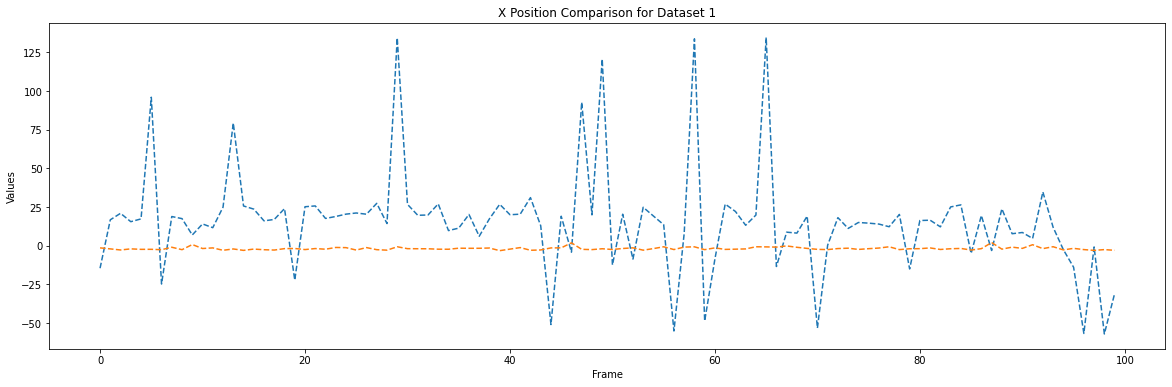

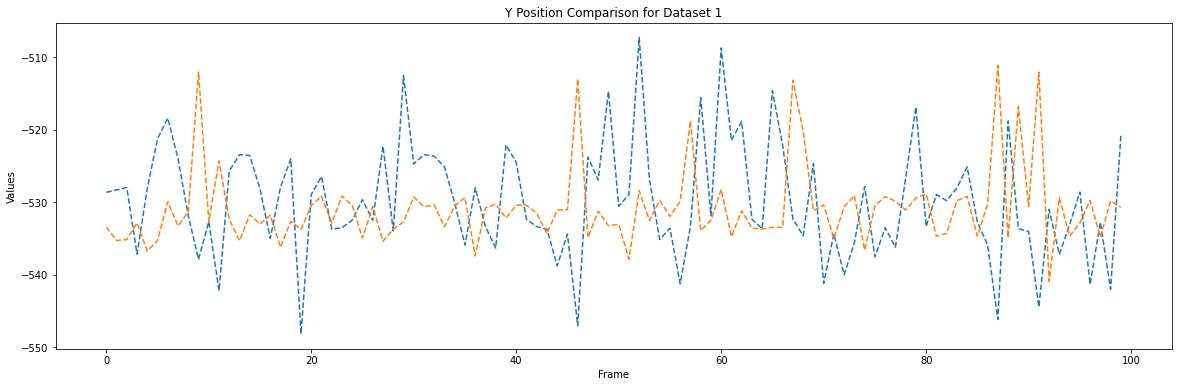

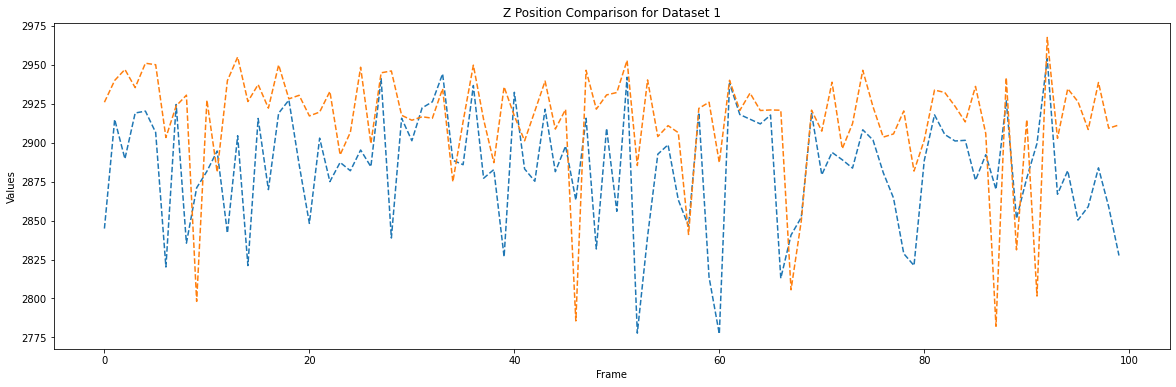

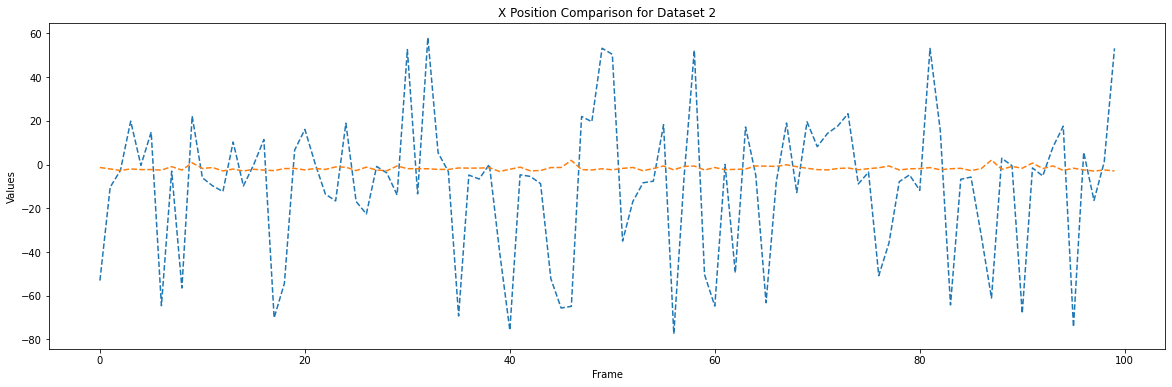

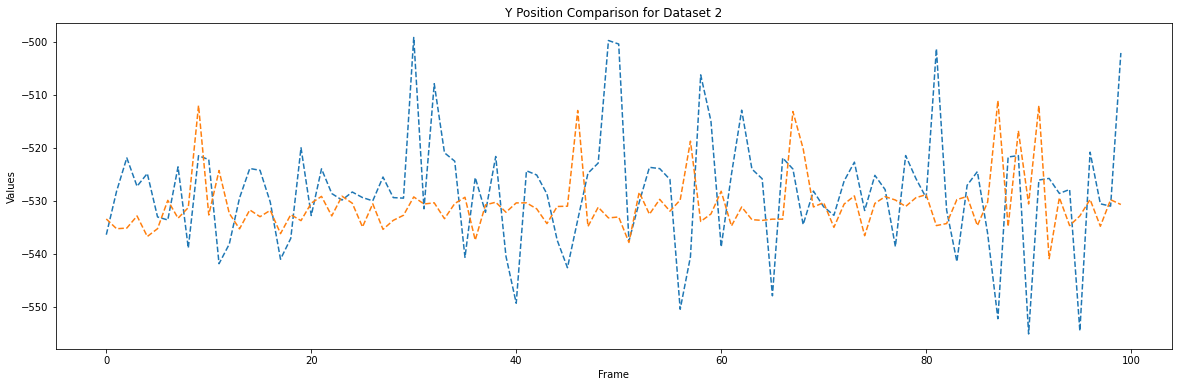

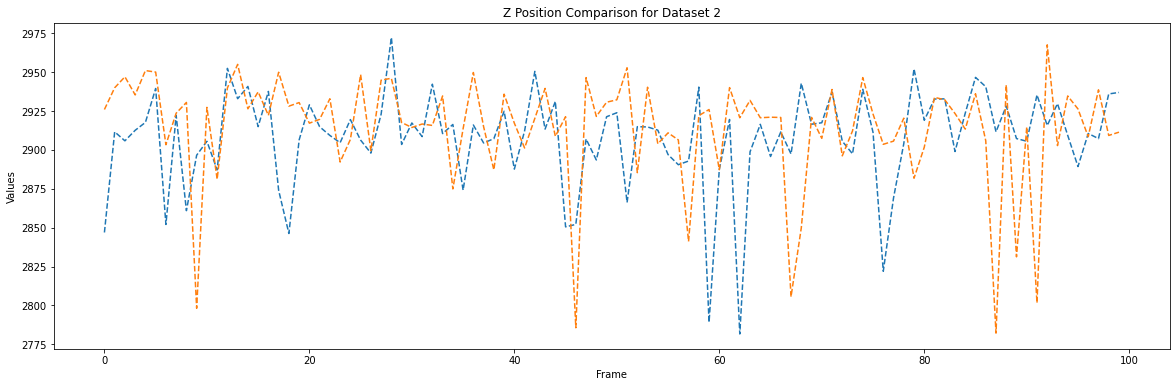

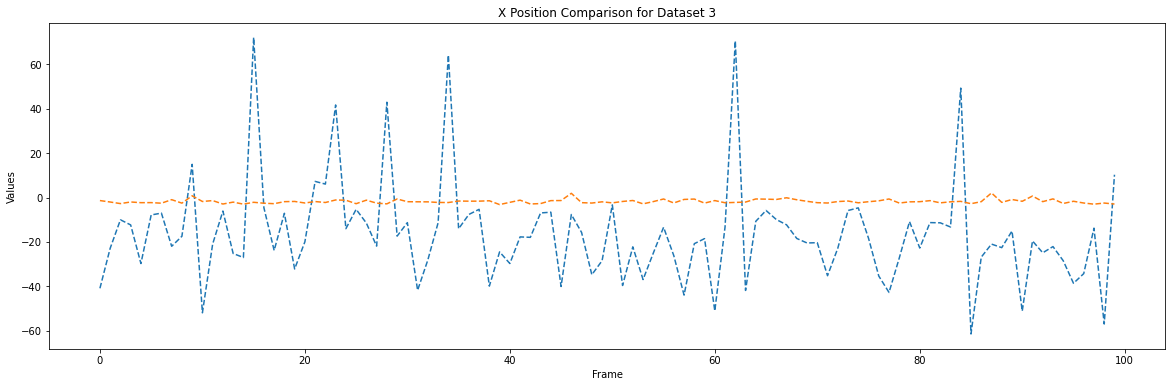

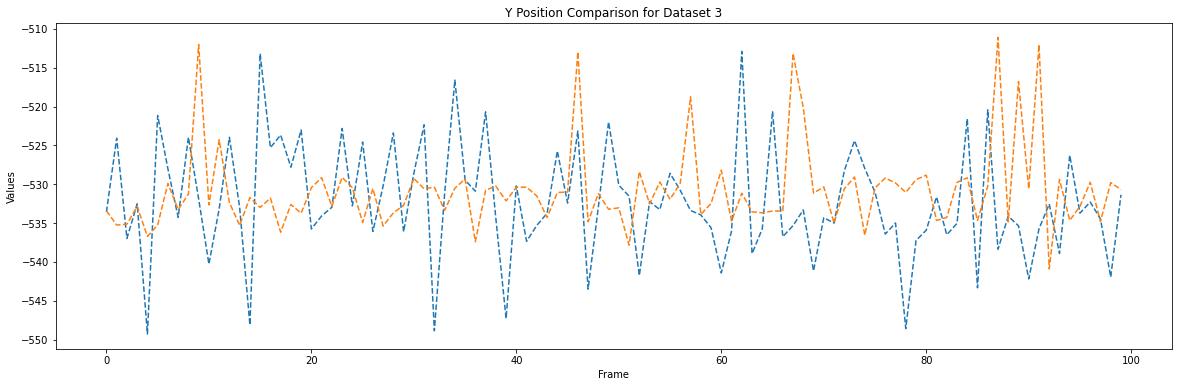

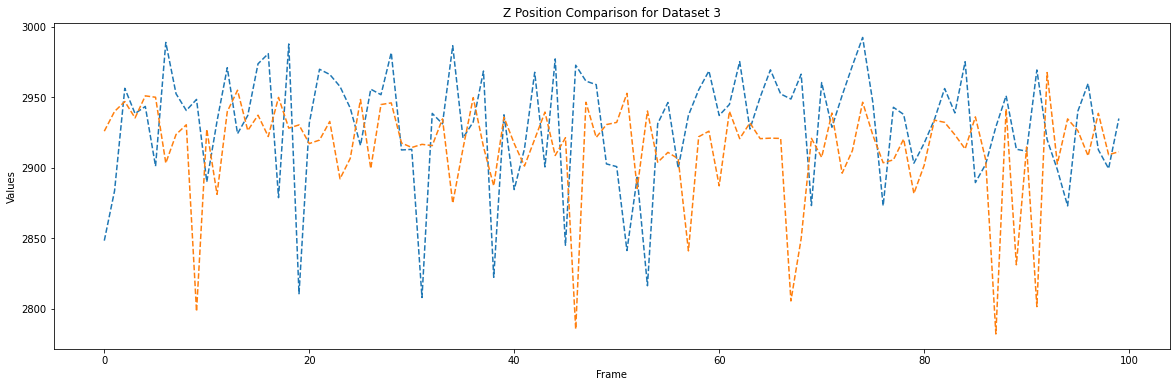

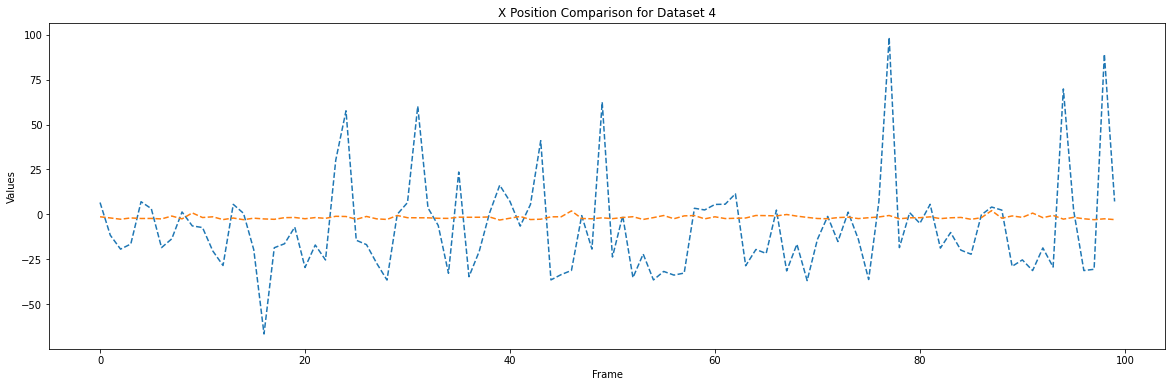

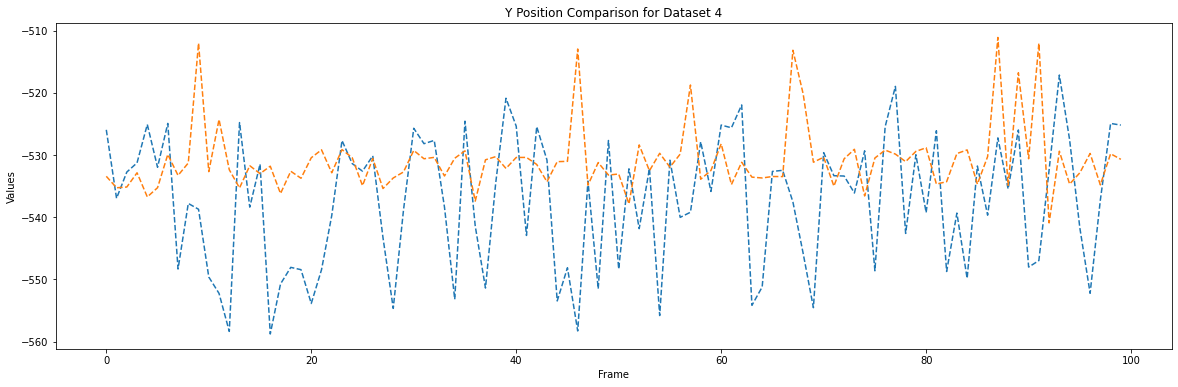

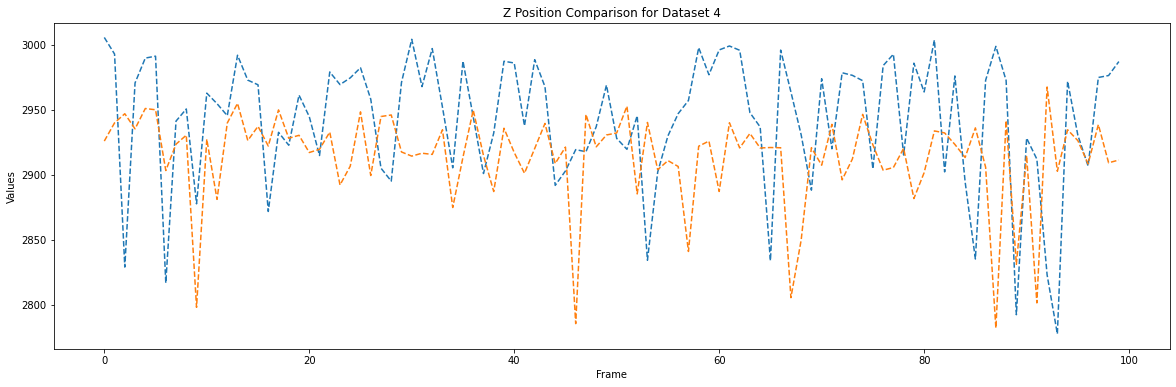

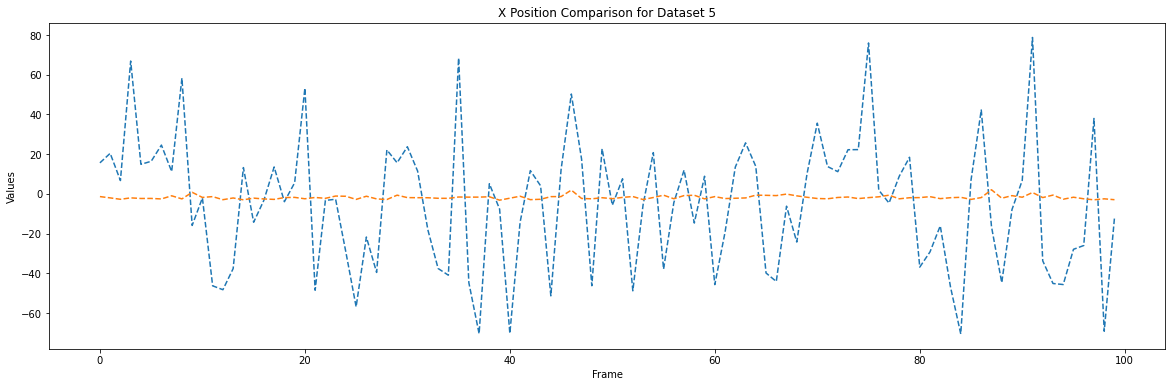

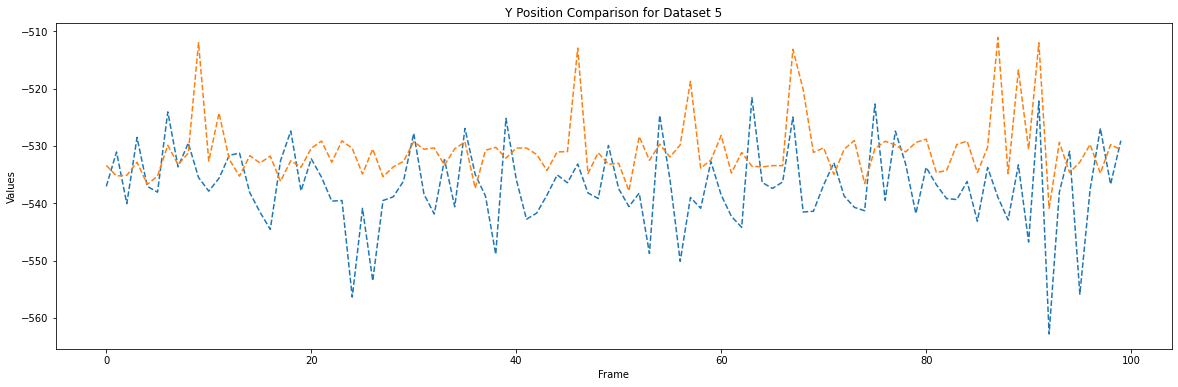

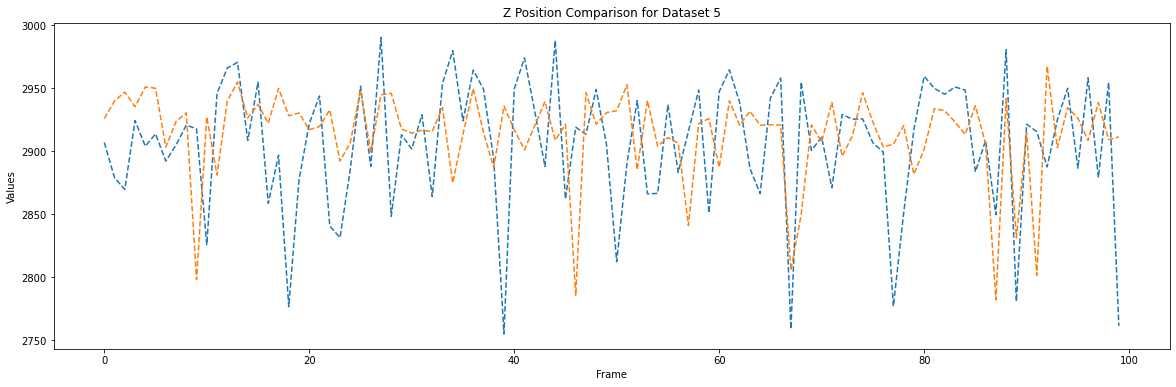

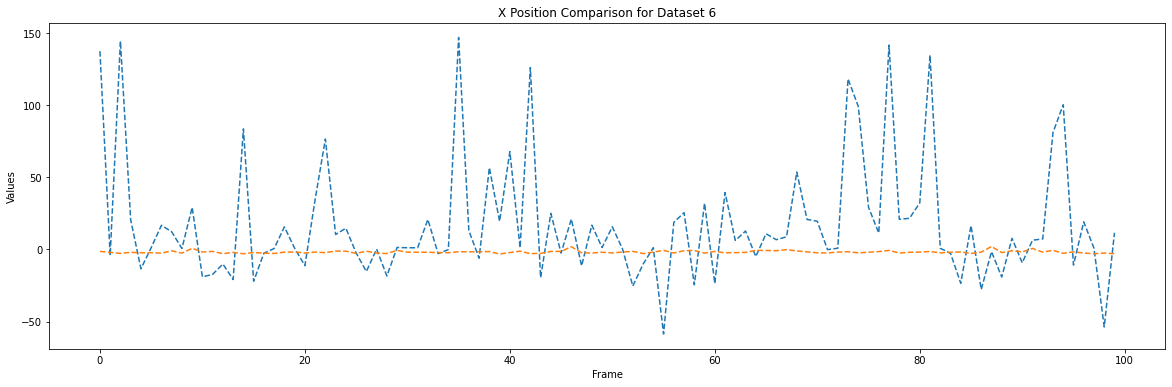

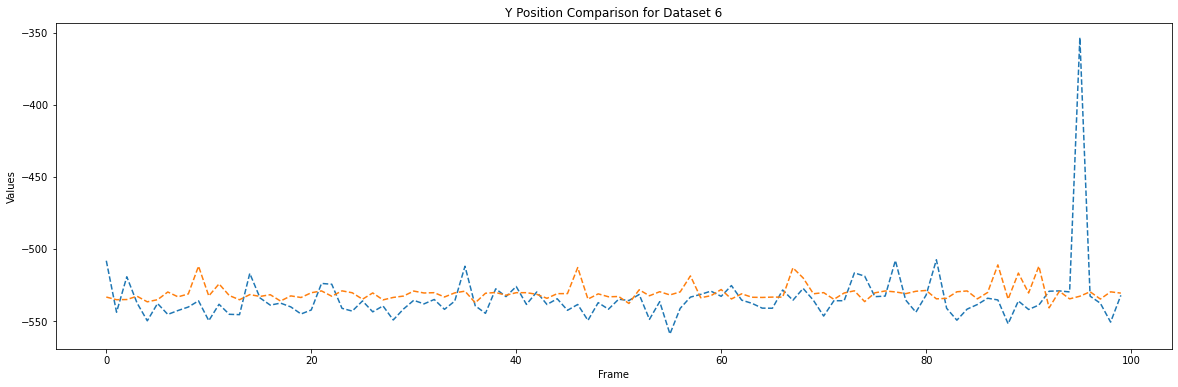

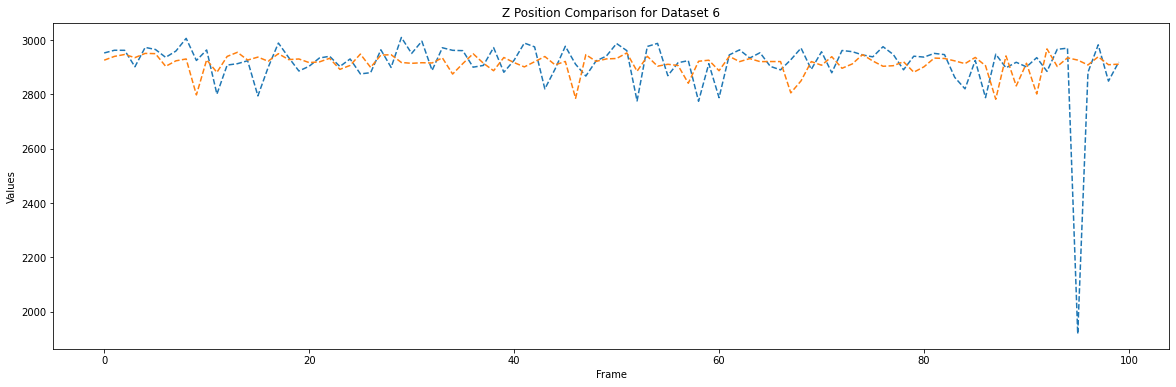

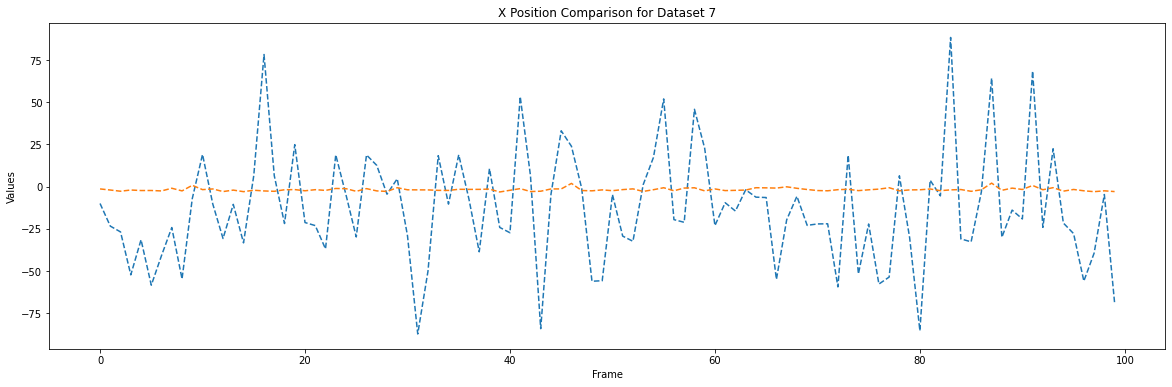

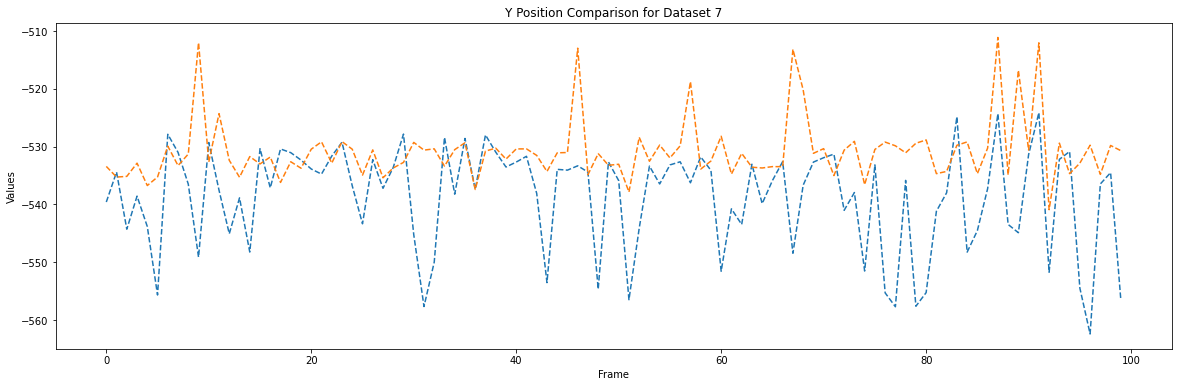

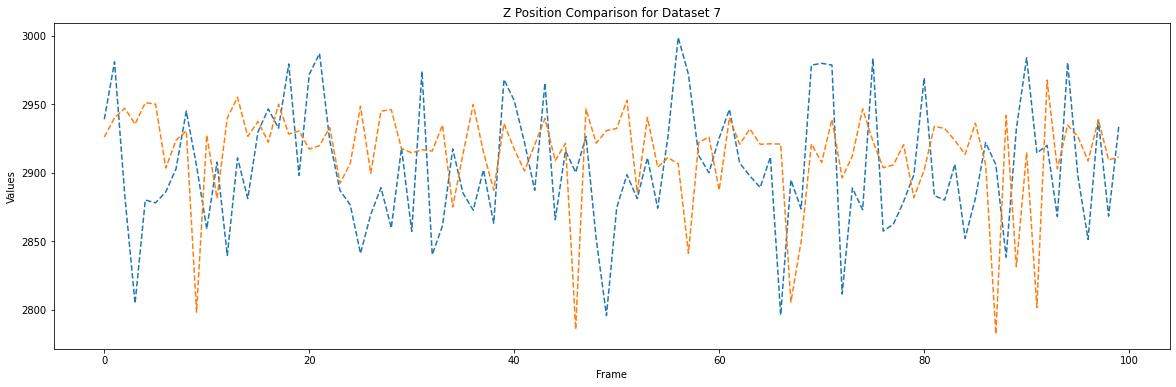

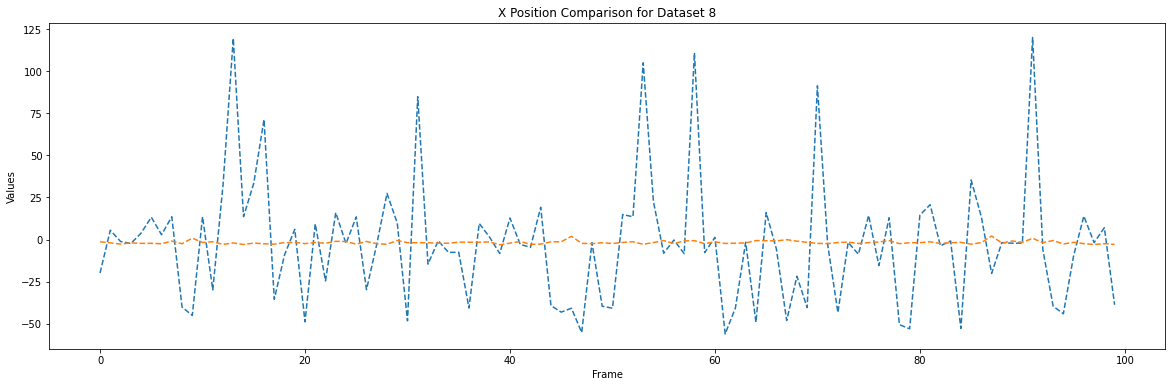

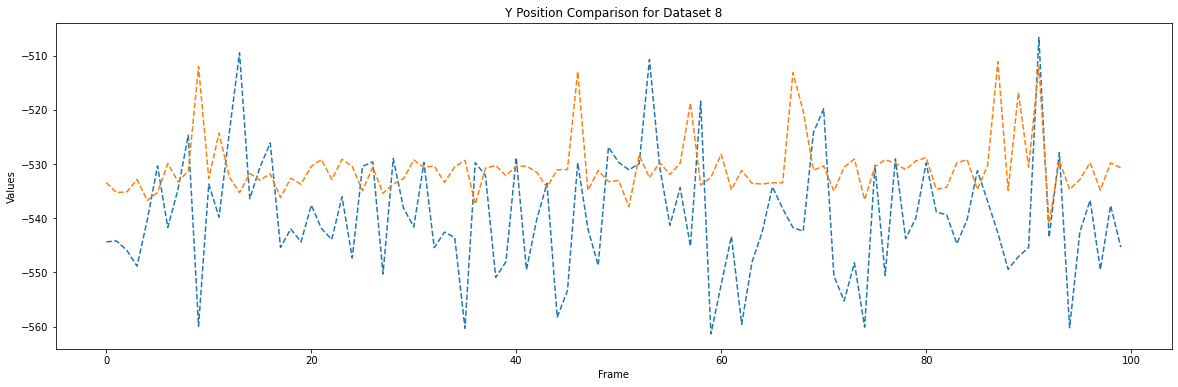

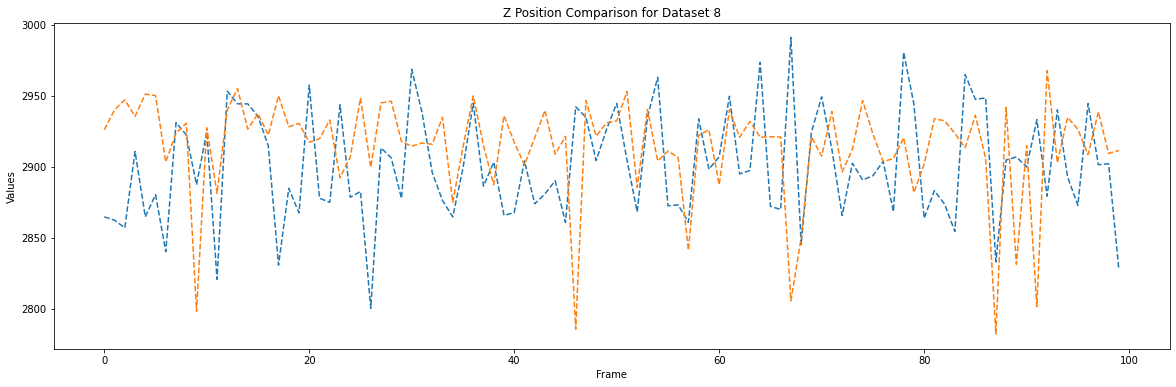

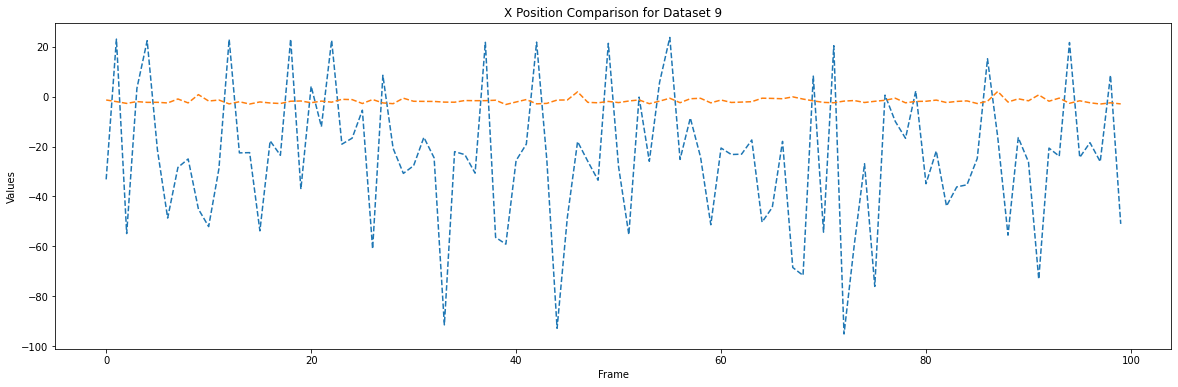

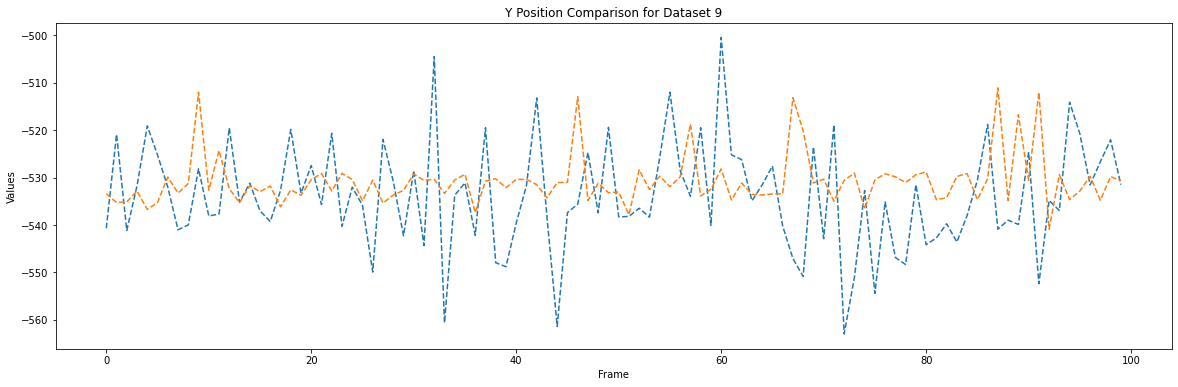

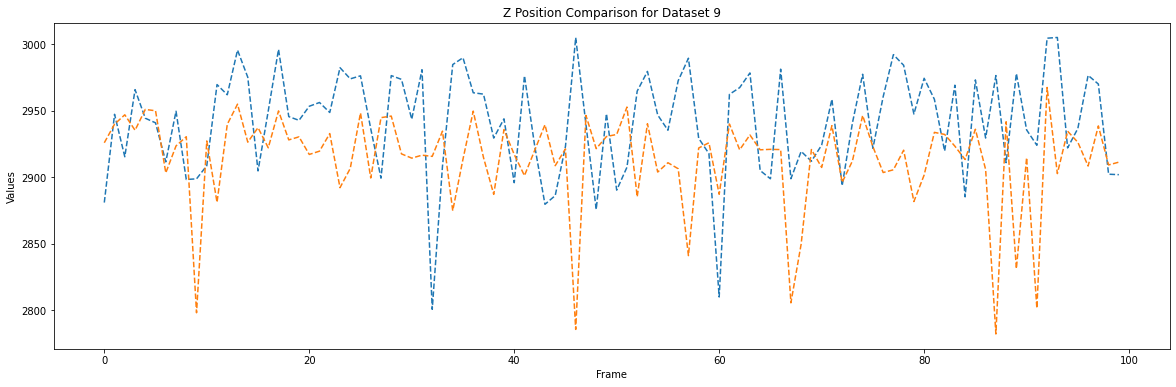

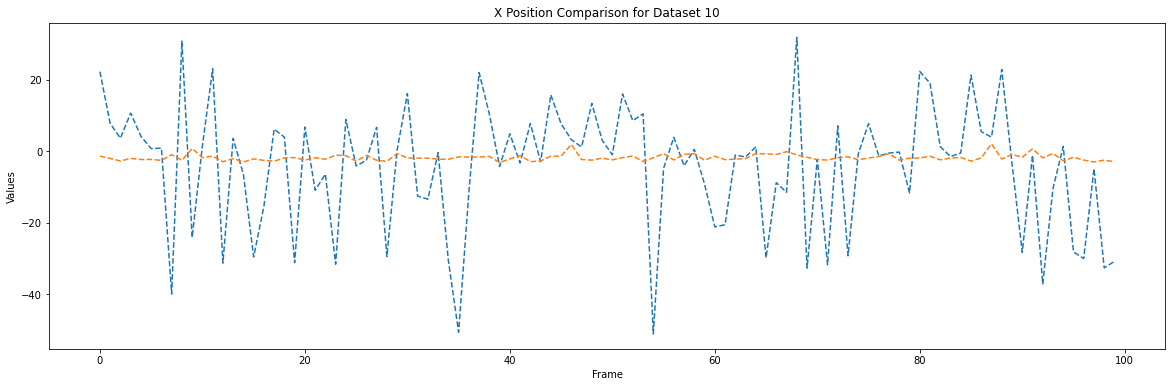

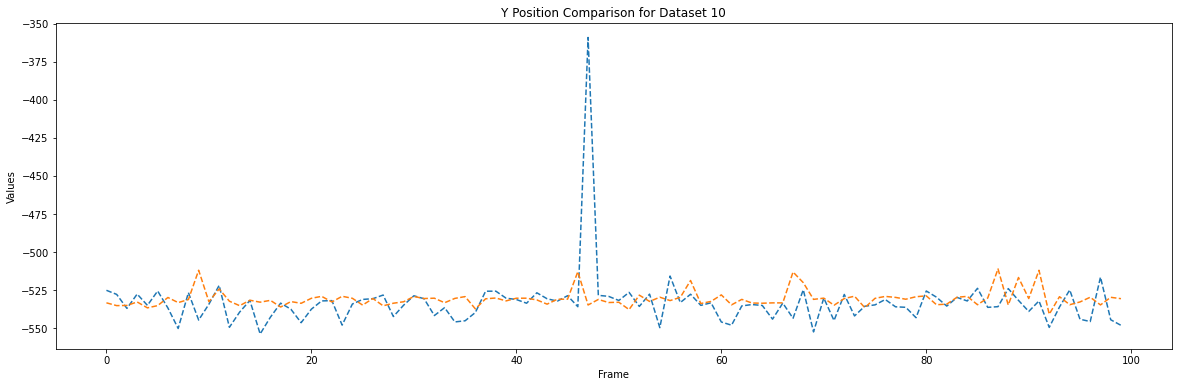

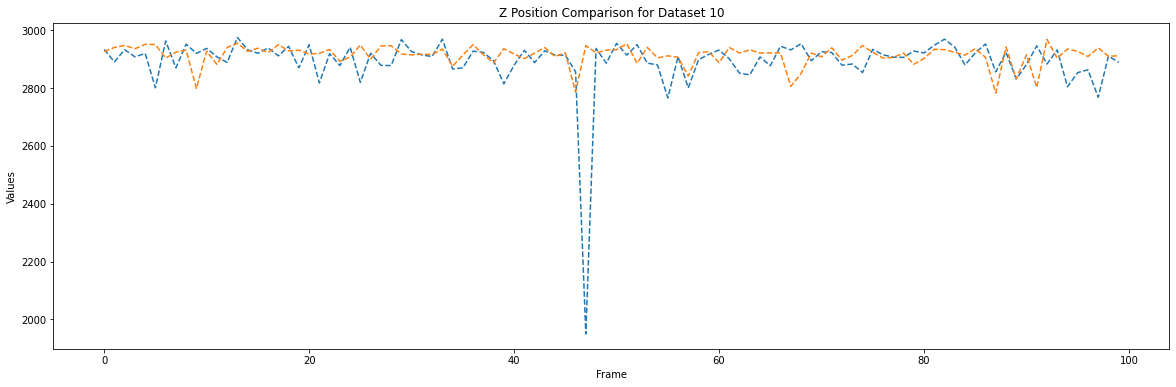

In [59]:
feature = 12 #this is for right wrist
lower = 0
upper = 100

for i in range(len(X_train)):
    plt.figure(figsize=(20, 6))

    plt.plot(y_test[i][lower:upper,feature], linestyle='--')
    plt.plot(PredictedArray[i][lower:upper,feature], linestyle='--')

    # Add labels and legend
    plt.xlabel('Frame')
    plt.ylabel('Values')
    plt.title(f'X Position Comparison for Dataset {i+1}')

    # Show the plot
    plt.show()

    plt.figure(figsize=(20, 6))

    plt.plot(y_test[i][lower:upper,feature+1], linestyle='--')
    plt.plot(PredictedArray[i][lower:upper,feature+1], linestyle='--')

    # Add labels and legend
    plt.xlabel('Frame')
    plt.ylabel('Values')
    plt.title(f'Y Position Comparison for Dataset {i+1}')

    # Show the plot
    plt.show()

    plt.figure(figsize=(20, 6))

    plt.plot(y_test[i][lower:upper,feature+2], linestyle='--')
    plt.plot(PredictedArray[i][lower:upper,feature+2], linestyle='--')

    # Add labels and legend
    plt.xlabel('Frame')
    plt.ylabel('Values')
    plt.title(f'Z Position Comparison for Dataset {i+1}')

    # Show the plot
    plt.show()
    

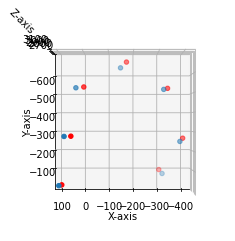

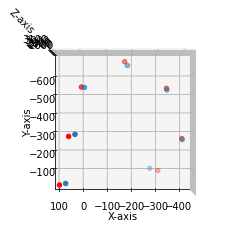

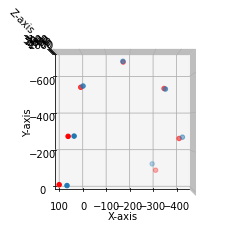

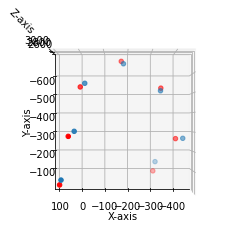

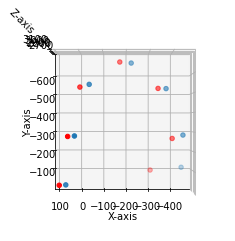

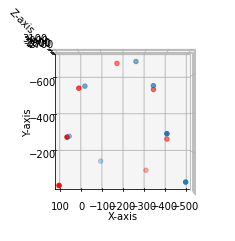

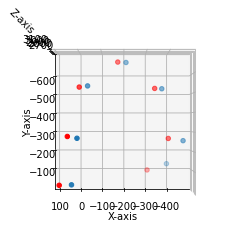

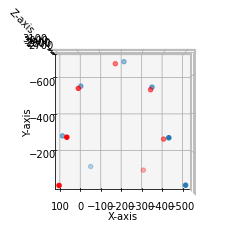

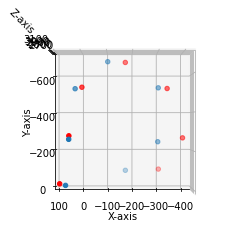

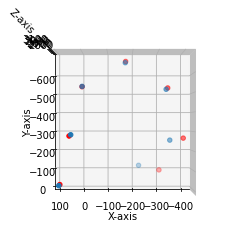

In [60]:
y_test_reshaped=[]
PredictedArray_shaped=[]
frame=100
for i in range(len(X_train)):
    y_test_reshaped = y_test[i][frame].reshape(-1,3)
    PredictedArray_shaped = PredictedArray[i][frame].reshape(-1,3)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points

    ax.scatter(y_test_reshaped[:, 0], y_test_reshaped[:, 1], y_test_reshaped[:, 2],marker='o')
    ax.scatter(PredictedArray_shaped[:, 0], PredictedArray_shaped[:, 1], PredictedArray_shaped[:, 2], c="red", marker='o')

    # Set axis labels
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.view_init(elev=90, azim=90)

    # Show the plot
    plt.show()
